# 시계열 데이터의 전처리  
- https://roadbook.co.kr/242 의 시계열 데이터(energydata.csv, event.csv)를 활용

## 1. 데이터 이해  
- 시계열 데이터를 대상으로 하는 전처리 방법을 알아보도록 하겠음
- 분석 목표는 6시간마다 전력소비량의 이상치를 검출하는 것

### 데이터 읽기와 확인

In [26]:
import pandas as pd

dat_df = pd.read_csv('./data/energydata.csv', sep=',')
dat_df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09


- 10분 간격으로 12개의 Column 값을 가진 시계열 데이터를 확인할 수 있음
- 시계열 데이터란 시간의 흐름에 따라 변화하면서 상호 간에 의존적인 관계가 성립되는 계열 데이터를 뜻함

In [27]:
print(dat_df.shape)

(17424, 13)


In [28]:
print(dat_df.dtypes)

date           object
Appliances      int64
lights          int64
T1            float64
RH_1          float64
T2            float64
RH_2          float64
T3            float64
RH_3          float64
T4            float64
RH_4          float64
T5            float64
RH_5          float64
dtype: object


In [29]:
dat_df['date'] = pd.to_datetime(dat_df['date'], format='%Y-%m-%d %H:%M:%S')
print(dat_df['date'].dtypes)
print(type(dat_df['date'][0]))

datetime64[ns]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


- to_datetime()을 사용하여 object형을 datatime 형으로 변환하였음
- date열은 datetime64, date열 속성은 Timestamp형으로 변환된 것을 확인할 수 있음

In [30]:
dat_df['dif_min'] = dat_df['date'].diff().dt.total_seconds()/60
dat_df['dif_min'] = dat_df['dif_min'].fillna(0)
dat_df['dif_min'].head()

0     0.0
1    10.0
2    10.0
3    10.0
4    10.0
Name: dif_min, dtype: float64

- diff()를 사용하여 한 행 전 값의 차이를 계산하였음
- total_seconds()를 통해 초 단위 값으로 출력이 되는데, 60으로 나누어서 분 단위로 변환하였음
- 행 0의 값은 NaN이기에 fiilna(0) 함수를 통해 0으로 대치하였음

In [31]:
dat_df['cum_min'] = dat_df['dif_min'].cumsum()
dat_df[['date', 'cum_min']].head()

,date,cum_min
0,2016-01-11 17:00:00,0.0
1,2016-01-11 17:10:00,10.0
2,2016-01-11 17:20:00,20.0
3,2016-01-11 17:30:00,30.0
4,2016-01-11 17:40:00,40.0


- cumsum()을 사용하여 dif_min의 누적 합계를 출력하였음

### 결손값 확인

In [32]:
print(dat_df.isnull().sum(axis=1).sort_values(ascending=False))
print(dat_df.isnull().sum(axis=0))

8586     1
11427    1
9699     1
14047    1
8604     1
        ..
11609    0
11608    0
11607    0
11606    0
0        0
Length: 17424, dtype: int64
date          0
Appliances    0
lights        0
T1            1
RH_1          0
T2            0
RH_2          1
T3            2
RH_3          0
T4            0
RH_4          0
T5            1
RH_5          0
dif_min       0
cum_min       0
dtype: int64


- isnull() 함수로 결손값 확인을 하였음

In [33]:
dat_df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,dif_min,cum_min
count,17424.000000,17424.000000,17423.000000,17424.000000,17424.000000,17423.000000,17422.000000,17424.000000,17424.000000,17424.000000,17423.000000,17424.000000,17424.000000,17424.000000
mean,97.136134,4.032943,21.370848,39.892301,19.960777,40.209553,21.851889,39.165869,20.437045,38.753288,19.198926,51.053839,9.999426,87115.000000
std,103.247863,8.131761,1.407637,3.716096,1.949825,3.836293,1.705699,3.210397,1.775985,4.274644,1.525227,9.092618,0.075758,50300.198807
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,30.663333,15.100000,27.660000,15.330000,29.815000,0.000000,0.000000
25%,50.000000,0.000000,20.600000,37.163333,18.666667,37.863333,20.600000,36.790000,19.338333,35.326667,18.100000,45.400000,10.000000,43557.500000
50%,60.000000,0.000000,21.390000,39.326667,19.700000,40.360000,21.790000,38.420667,20.390000,38.133333,19.100000,48.900000,10.000000,87115.000000
75%,100.000000,0.000000,22.200000,42.566875,20.926667,43.000000,22.890000,41.433333,21.500000,41.658333,20.200000,53.830278,10.000000,130672.500000
max,1080.000000,70.000000,25.700000,63.360000,29.856667,56.026667,27.600000,50.163333,26.200000,51.090000,25.745000,96.321667,10.000000,174230.000000


### 데이터 시각화
- Matplotlib를 활용하여 데이터를 시각화하고 분포를 확인할 수 있음

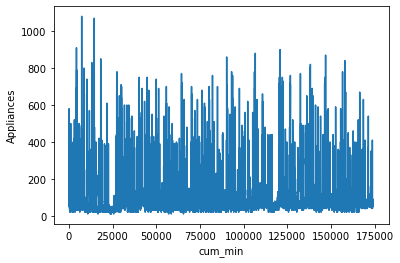

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(dat_df['cum_min'], dat_df['Appliances'])

plt.xlabel('cum_min')
plt.ylabel('Appliances')
plt.show()

- Appliances(가전 제품전력량)의 추이를 확인할 수 있음
- 좀 더 구체적인 추이를 보기 위해 기간을 정해야할 것으로 보임

## 2. 데이터 준비
### 데이터 읽기와 확인

In [35]:
import pandas as pd

dat_df = pd.read_csv('./data/energydata.csv', sep=',')

### 결손값 보완
- 시계열 데이터는 연속 데이터이기에, 데이터의 순서에 의미가 있음
- 따라서, 항목을 0 혹은 정수, 평균치로 보완하면 연속성이 없어져 버리기에 전 행의 값이나 전후의 값으로 보완하는 것이 바람직함

In [36]:
dat_df[8585:8588]

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
8585,2016-03-11 07:50:00,70,0,20.2,37.160000,16.5,42.430000,20.39,37.500000,19.700000,34.360000,18.000000,46.660000
8586,2016-03-11 08:00:00,280,0,20.2,37.463333,16.6,42.766667,NaN,37.500000,19.700000,34.633333,18.066667,46.193333
8587,2016-03-11 08:10:00,180,10,20.2,37.530000,16.6,42.966667,20.29,37.363333,19.666667,34.723333,18.100000,45.723333


- 결과를 통해 8586의 T3 속성 값이 NaN인 것을 확인할 수 있음

In [37]:
dat_df[8585:8588].fillna(method='ffill')

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
8585,2016-03-11 07:50:00,70,0,20.2,37.160000,16.5,42.430000,20.39,37.500000,19.700000,34.360000,18.000000,46.660000
8586,2016-03-11 08:00:00,280,0,20.2,37.463333,16.6,42.766667,20.39,37.500000,19.700000,34.633333,18.066667,46.193333
8587,2016-03-11 08:10:00,180,10,20.2,37.530000,16.6,42.966667,20.29,37.363333,19.666667,34.723333,18.100000,45.723333


In [38]:
dat_df[8585:8588].fillna(method='bfill')

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
8585,2016-03-11 07:50:00,70,0,20.2,37.160000,16.5,42.430000,20.39,37.500000,19.700000,34.360000,18.000000,46.660000
8586,2016-03-11 08:00:00,280,0,20.2,37.463333,16.6,42.766667,20.29,37.500000,19.700000,34.633333,18.066667,46.193333
8587,2016-03-11 08:10:00,180,10,20.2,37.530000,16.6,42.966667,20.29,37.363333,19.666667,34.723333,18.100000,45.723333


In [39]:
dat_df = dat_df.interpolate()
dat_df[8585:8588]

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
8585,2016-03-11 07:50:00,70,0,20.2,37.160000,16.5,42.430000,20.39,37.500000,19.700000,34.360000,18.000000,46.660000
8586,2016-03-11 08:00:00,280,0,20.2,37.463333,16.6,42.766667,20.34,37.500000,19.700000,34.633333,18.066667,46.193333
8587,2016-03-11 08:10:00,180,10,20.2,37.530000,16.6,42.966667,20.29,37.363333,19.666667,34.723333,18.100000,45.723333


- NaN값을 포함한 전후의 행을 대상으로 fillna(method='ffill', 'bfill')을 통해 전 후의 값을 대치할 수 있음
- 아울러, interpolate()를 통해 결손값의 전후의 값 평균치로 보완한 것을 볼 수 있음

### 시간축 작성
- 6시간마다 전력소비랑의 이상을 검출하기 위해 6시간을 기준으로 데이터를 전처리 수행

In [40]:
dat_df['date'] = pd.to_datetime(dat_df['date'], format='%Y-%m-%d %H:%M:%S')
dat_df['dif_min'] = dat_df['date'].diff().dt.total_seconds()/60
dat_df['dif_min'] = dat_df['dif_min'].fillna(0)
dat_df['cum_min'] = dat_df['dif_min'].cumsum()
dat_df[['date', 'cum_min']].head()

,date,cum_min
0,2016-01-11 17:00:00,0.0
1,2016-01-11 17:10:00,10.0
2,2016-01-11 17:20:00,20.0
3,2016-01-11 17:30:00,30.0
4,2016-01-11 17:40:00,40.0


In [41]:
dat_df['cum_6hour'] = (dat_df['cum_min']/360).round(2).astype(int)

print(dat_df['cum_6hour'].unique())
dat_df[['date', 'cum_min', 'cum_6hour']].head(50)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

,date,cum_min,cum_6hour
0,2016-01-11 17:00:00,0.0,0
1,2016-01-11 17:10:00,10.0,0
2,2016-01-11 17:20:00,20.0,0
3,2016-01-11 17:30:00,30.0,0
4,2016-01-11 17:40:00,40.0,0
5,2016-01-11 17:50:00,50.0,0
6,2016-01-11 18:00:00,60.0,0
7,2016-01-11 18:10:00,70.0,0
8,2016-01-11 18:20:00,80.0,0
9,2016-01-11 18:30:00,90.0,0


### 특징량 작성 (1)
- 6시간 단위로 각 항목의 통계량(평균치와 표준편차)을 계산

In [42]:
dat_df = dat_df.drop(['date', 'dif_min', 'cum_min'], axis=1)
dat_df_mean = dat_df.groupby('cum_6hour').mean()

print(dat_df_mean.shape)
dat_df_mean.head()

(484, 12)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
cum_6hour,,,,,,,,,,,,
0,150.000000,31.944444,20.688056,47.345394,20.023148,44.973287,20.111481,46.041875,19.255972,47.379074,17.761597,60.359861
1,81.944444,7.222222,20.858287,45.627708,20.227315,44.286435,20.213588,45.530833,20.740093,46.503634,18.898519,50.261273
2,83.333333,5.555556,19.860463,47.019213,19.140608,44.876698,20.149722,45.269306,19.349259,45.893611,18.163125,50.817454
3,101.111111,0.000000,20.037500,44.843009,19.103377,43.495476,19.907778,44.802407,19.748287,43.536204,17.835370,50.444111
4,78.611111,7.222222,19.947963,43.275394,19.113860,42.606633,19.788704,44.312037,19.555093,42.804491,17.477870,50.732546


In [44]:
dat_df_std = dat_df.groupby('cum_6hour').std()

print(dat_df_std.shape)
dat_df_std.head()

(484, 12)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
cum_6hour,,,,,,,,,,,,
0,131.366445,13.901582,0.672443,2.998070,0.653222,0.848637,0.278809,1.185530,0.485747,1.282966,0.791008,9.891611
1,101.497908,9.137399,0.460572,0.811346,0.476669,0.342190,0.082826,0.103003,0.560148,0.511257,0.272610,0.339389
2,104.853639,9.085135,0.103157,1.039938,0.167655,0.318816,0.142110,0.261039,0.273491,0.776746,0.178471,1.138170
3,95.999339,0.000000,0.059026,1.091231,0.069944,0.617057,0.046289,0.068936,0.274278,0.622986,0.164863,0.792715
4,83.773599,12.097488,0.151195,0.561101,0.187641,0.418215,0.048003,0.180349,0.341428,0.430826,0.075740,0.247231


In [45]:
dat_features = pd.merge(dat_df_mean, dat_df_std, left_index=True, right_index=True)

print(dat_features.shape)
dat_features.head()

(484, 24)


,Appliances_x,lights_x,T1_x,RH_1_x,T2_x,RH_2_x,T3_x,RH_3_x,T4_x,RH_4_x,...,T1_y,RH_1_y,T2_y,RH_2_y,T3_y,RH_3_y,T4_y,RH_4_y,T5_y,RH_5_y
cum_6hour,,,,,,,,,,,,,,,,,,,,,
0,150.000000,31.944444,20.688056,47.345394,20.023148,44.973287,20.111481,46.041875,19.255972,47.379074,...,0.672443,2.998070,0.653222,0.848637,0.278809,1.185530,0.485747,1.282966,0.791008,9.891611
1,81.944444,7.222222,20.858287,45.627708,20.227315,44.286435,20.213588,45.530833,20.740093,46.503634,...,0.460572,0.811346,0.476669,0.342190,0.082826,0.103003,0.560148,0.511257,0.272610,0.339389
2,83.333333,5.555556,19.860463,47.019213,19.140608,44.876698,20.149722,45.269306,19.349259,45.893611,...,0.103157,1.039938,0.167655,0.318816,0.142110,0.261039,0.273491,0.776746,0.178471,1.138170
3,101.111111,0.000000,20.037500,44.843009,19.103377,43.495476,19.907778,44.802407,19.748287,43.536204,...,0.059026,1.091231,0.069944,0.617057,0.046289,0.068936,0.274278,0.622986,0.164863,0.792715
4,78.611111,7.222222,19.947963,43.275394,19.113860,42.606633,19.788704,44.312037,19.555093,42.804491,...,0.151195,0.561101,0.187641,0.418215,0.048003,0.180349,0.341428,0.430826,0.075740,0.247231


- mean(), std()를 활용하여 평균과 표준편차 값을 계산하였음
- 아울러 merge()를 통해 두개의 결과 값이 통합된 것을 확인할 수 있음
- 컬럼명의 값으므로, dat_df_mean 값에 _x, dat_df_std 값에 _y가 붙여진 것을 확인할 수 있음

### 목적변수 작성
- 전력소비량에 이상이 발생한 날짜의 로그 데이터인 'event.csv'를 활용하여 목적변수를 작성하겠음

In [46]:
event_df = pd.read_csv('./data/event.csv', sep=',')
event_df.head()

,date
0,2016-01-12 10:00:00
1,2016-01-13 21:00:00
2,2016-01-14 10:00:00
3,2016-01-14 16:00:00
4,2016-01-14 17:00:00


In [50]:
import datetime as dt

event_df['date'] = pd.to_datetime(event_df['date'], format = '%Y-%m-%d %H:%M:%S')

base_time = '2016-01-11 17:00:00'
event_df['dif_min'] = event_df['date'] - dt.datetime.strptime(base_time, '%Y-%m-%d %H:%M:%S')
event_df['dif_min'] = event_df['dif_min'].dt.total_seconds()/60
event_df['cum_6hour'] = (event_df['dif_min']/360).round(2).astype(int)

event_df.head()

,date,dif_min,cum_6hour
0,2016-01-12 10:00:00,1020.0,2
1,2016-01-13 21:00:00,3120.0,8
2,2016-01-14 10:00:00,3900.0,10
3,2016-01-14 16:00:00,4260.0,11
4,2016-01-14 17:00:00,4320.0,12


- 기준 날짜를 정의하고, 각 날짜와의 시간차를 계산

In [51]:
event_df['event'] = 1

event_df = event_df[['cum_6hour', 'event']]
event_df = event_df[~event_df.duplicated()]

event_df = event_df.set_index(['cum_6hour'])

event_df.head()

,event
cum_6hour,
2,1
8,1
10,1
11,1
12,1


- 이상이 발생한 것으로 정의하여 작성
- duplicated()를 사용해 중복되는 행 제거

In [52]:
dat_event = dat_features.join(event_df, how='left')
dat_event = dat_event.fillna(0)

print(dat_event.shape)
dat_event.head()

(484, 25)


,Appliances_x,lights_x,T1_x,RH_1_x,T2_x,RH_2_x,T3_x,RH_3_x,T4_x,RH_4_x,...,RH_1_y,T2_y,RH_2_y,T3_y,RH_3_y,T4_y,RH_4_y,T5_y,RH_5_y,event
cum_6hour,,,,,,,,,,,,,,,,,,,,,
0,150.000000,31.944444,20.688056,47.345394,20.023148,44.973287,20.111481,46.041875,19.255972,47.379074,...,2.998070,0.653222,0.848637,0.278809,1.185530,0.485747,1.282966,0.791008,9.891611,0.0
1,81.944444,7.222222,20.858287,45.627708,20.227315,44.286435,20.213588,45.530833,20.740093,46.503634,...,0.811346,0.476669,0.342190,0.082826,0.103003,0.560148,0.511257,0.272610,0.339389,0.0
2,83.333333,5.555556,19.860463,47.019213,19.140608,44.876698,20.149722,45.269306,19.349259,45.893611,...,1.039938,0.167655,0.318816,0.142110,0.261039,0.273491,0.776746,0.178471,1.138170,1.0
3,101.111111,0.000000,20.037500,44.843009,19.103377,43.495476,19.907778,44.802407,19.748287,43.536204,...,1.091231,0.069944,0.617057,0.046289,0.068936,0.274278,0.622986,0.164863,0.792715,0.0
4,78.611111,7.222222,19.947963,43.275394,19.113860,42.606633,19.788704,44.312037,19.555093,42.804491,...,0.561101,0.187641,0.418215,0.048003,0.180349,0.341428,0.430826,0.075740,0.247231,0.0


- 특징량인 평균치와 표준편차를 합해 24개의 열과 목적변수(라벨)는 1열로 정의된 것을 확인할 수 있음

### 특징량 작성 (2)
- 앞서 작성한 특징량 (1)에서 6시간 분량의 시계열 데이터 36점을 1점에 집약시켰음 (6시간 : 360분)
- 정보를 과도하게 집약시키면, 데이터가 시사하는 바가 붇히게 되므로 주의해야함
- 슬라이드 창을 사용해서 좀 더 상세한 특징량을 만들 수 있음
- 시계열 데이터에 대해서 폭이 일정한 창을 작성하고, 데이터를 한 개씩 슬라이드하면서 부분시계열 데이터를 추출해 구간의 통계량(평균값과 표준편차을 특징량으로 하는 것임

In [53]:
tmp = dat_df[dat_df['cum_6hour'] == 0]
tmp = tmp.drop(['cum_6hour'], axis=1)

tmp = tmp.rolling(6).mean()
tmp = tmp.dropna()

tmp

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5
5,55.000000,35.000000,19.890000,46.502778,19.200000,44.626528,19.790000,44.897778,18.932778,45.738750,17.166667,55.116667
6,55.000000,38.333333,19.890000,46.197778,19.200000,44.578194,19.790000,44.926111,18.914444,45.775972,17.155556,55.077778
7,55.000000,41.666667,19.884444,46.008889,19.200000,44.541111,19.780000,44.944444,18.896111,45.754444,17.144444,55.027778
8,56.666667,43.333333,19.867778,45.891806,19.200000,44.508889,19.770000,44.920556,18.890000,45.737778,17.144444,55.012778
9,60.000000,43.333333,19.862222,45.895694,19.205000,44.477222,19.770000,44.897778,18.890000,45.800000,17.133333,54.997778
10,88.333333,48.333333,19.868333,45.817361,19.231111,44.455556,19.770000,44.881111,18.890000,45.950000,17.116667,54.982778
11,176.666667,51.666667,19.897778,45.879028,19.268889,44.438889,19.770000,44.863333,18.908333,46.066667,17.111111,54.977778
12,238.333333,51.666667,19.938333,46.251250,19.330000,44.422222,19.786667,44.863333,18.926667,46.162222,17.111111,54.998333
13,270.000000,50.000000,20.005556,47.445694,19.418333,44.522222,19.813333,44.962222,18.945000,46.388889,17.111111,55.042222
14,276.666667,45.000000,20.111667,49.161667,19.527778,44.755556,19.863889,45.418333,18.963333,46.873333,17.100000,55.125556


- 데이터 셋의 인덱스가 슬라이드 창의 인덱스에 해당함
- 각각의 항목과 각 슬라이드 창의 평균값이 저장되어있음

In [54]:
import numpy as np

tmp2 = (np.array(tmp['Appliances']).tolist() + np.array(tmp['lights']).tolist() + 
        np.array(tmp['T1']).tolist() + np.array(tmp['RH_1']).tolist() + 
        np.array(tmp['T2']).tolist() + np.array(tmp['RH_2']).tolist() + 
        np.array(tmp['T3']).tolist() + np.array(tmp['RH_3']).tolist() + 
        np.array(tmp['T4']).tolist() + np.array(tmp['RH_4']).tolist() + 
        np.array(tmp['T5']).tolist() + np.array(tmp['RH_5']).tolist())

print(len(tmp2))
pd.DataFrame(tmp2).T

372


,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
0,55.0,55.0,55.0,56.666667,60.0,88.333333,176.666667,238.333333,270.0,276.666667,...,78.903333,76.02,72.648889,69.037778,64.516667,59.767222,56.83,55.170417,53.997083,53.129306


- 머신러닝 알고리즘에 적합한 형태로 변형하였음
- 6시간 단위의 특징량은 총 372개로 전치행렬을 적용하여 행으로 표현하였음

In [55]:
hid = dat_df['cum_6hour'].unique()

dat_slide_features = []

for i in range(len(hid)):
    tmp = dat_df[dat_df['cum_6hour'] == i]
    tmp = tmp.drop(['cum_6hour'], axis=1)

    tmp_mean = tmp.rolling(6).mean()
    tmp_mean = tmp_mean.dropna()
    tmp_std = tmp.rolling(6).mean()
    tmp_std = tmp_std.dropna()    

    tmp2 = (np.array(tmp_mean['Appliances']).tolist() + np.array(tmp_mean['lights']).tolist() + 
            np.array(tmp_mean['T1']).tolist() + np.array(tmp_mean['RH_1']).tolist() + 
            np.array(tmp_mean['T2']).tolist() + np.array(tmp_mean['RH_2']).tolist() + 
            np.array(tmp_mean['T3']).tolist() + np.array(tmp_mean['RH_3']).tolist() + 
            np.array(tmp_mean['T4']).tolist() + np.array(tmp_mean['RH_4']).tolist() + 
            np.array(tmp_mean['T5']).tolist() + np.array(tmp_mean['RH_5']).tolist() + 
            np.array(tmp_std['Appliances']).tolist() + np.array(tmp_std['lights']).tolist() + 
            np.array(tmp_std['T1']).tolist() + np.array(tmp_std['RH_1']).tolist() + 
            np.array(tmp_std['T2']).tolist() + np.array(tmp_std['RH_2']).tolist() + 
            np.array(tmp_std['T3']).tolist() + np.array(tmp_std['RH_3']).tolist() + 
            np.array(tmp_std['T4']).tolist() + np.array(tmp_std['RH_4']).tolist() + 
            np.array(tmp_std['T5']).tolist() + np.array(tmp_std['RH_5']).tolist())

    dat_slide_features.append(tmp2)

In [56]:
dat_slide_features = pd.DataFrame(dat_slide_features)

print(dat_slide_features.shape)
dat_slide_features.head()

(484, 744)


,0,1,2,3,4,5,6,7,8,9,...,734,735,736,737,738,739,740,741,742,743
0,55.000000,55.000000,55.000000,56.666667,60.000000,88.333333,176.666667,238.333333,270.000000,276.666667,...,78.903333,76.020000,72.648889,69.037778,64.516667,59.767222,56.830000,55.170417,53.997083,53.129306
1,56.666667,53.333333,48.333333,46.666667,43.333333,85.000000,141.666667,198.333333,255.000000,268.333333,...,50.090000,50.080000,50.065000,50.050000,50.035000,50.020000,50.005000,50.000000,50.000000,50.000000
2,43.333333,43.333333,46.666667,46.666667,45.000000,41.666667,40.000000,38.333333,35.000000,38.333333,...,52.633333,52.572222,52.305556,51.950000,51.473333,50.951111,50.407778,49.995556,49.783333,49.640000
3,55.000000,56.666667,80.000000,108.333333,126.666667,181.666667,186.666667,186.666667,203.333333,188.333333,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.010000,51.010000,51.010000,51.004444,50.987778
4,218.333333,221.666667,226.666667,203.333333,146.666667,91.666667,58.333333,53.333333,46.666667,45.000000,...,50.601111,50.536111,50.481111,50.437222,50.397222,50.362222,50.338889,50.350000,50.371667,50.427778


- 결과를 통해 484행, 744열의 결과를 확인할 수 있음
- 특징량은 평균치와 표준편차를 합해 744열이며, 목적변수(event)는 1개임
- Two-Class Classification에 적용이 가능한 데이터 셋임

## 3. 훈련 데이터 작성  
### 데이터 읽기와 확인

In [59]:
import pandas as pd

dat_df = pd.read_csv('./data/energydata.csv', sep=',')[['date', 'Appliances']]
dat_df['date'] = pd.to_datetime(dat_df['date'], format='%Y-%m-%d %H:%M:%S')

dat_df.head()

,date,Appliances
0,2016-01-11 17:00:00,60
1,2016-01-11 17:10:00,60
2,2016-01-11 17:20:00,50
3,2016-01-11 17:30:00,50
4,2016-01-11 17:40:00,60


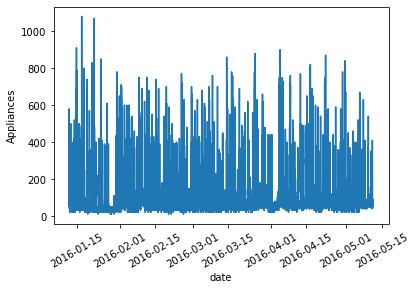

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(dat_df['date'], dat_df['Appliances'])
plt.xlabel('date')
plt.xticks(rotation=30)
plt.ylabel('Appliances')
plt.show()

- 전력사용량의 시간에 따른 변화를 볼 수 있음

### K-NN법에 의한 훈련 데이터 작성

In [61]:
train = dat_df[dat_df['date'] < '2016-04-11 17:00:00']
print(train.shape)

test = dat_df[dat_df['date'] >= '2016-04-11 17:00:00']
print(test.shape)

(13104, 2)
(4320, 2)


In [62]:
from sklearn.preprocessing import MinMaxScaler

mc = MinMaxScaler()
train = mc.fit_transform(train[['Appliances']])
test = mc.fit_transform(test[['Appliances']])

In [63]:
width = 144

train = train.flatten()
train_vec = []

for i in range(len(train)-width):
    train_vec.append(train[i:i+width])

print(pd.DataFrame(train_vec).shape)
pd.DataFrame(train_vec).head()

(12960, 144)


,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0.046729,0.046729,0.037383,0.037383,0.046729,0.037383,0.046729,0.046729,0.046729,0.056075,...,0.028037,0.018692,0.018692,0.018692,0.018692,0.028037,0.037383,0.028037,0.028037,0.028037
1,0.046729,0.037383,0.037383,0.046729,0.037383,0.046729,0.046729,0.046729,0.056075,0.205607,...,0.018692,0.018692,0.018692,0.018692,0.028037,0.037383,0.028037,0.028037,0.028037,0.046729
2,0.037383,0.037383,0.046729,0.037383,0.046729,0.046729,0.046729,0.056075,0.205607,0.532710,...,0.018692,0.018692,0.018692,0.028037,0.037383,0.028037,0.028037,0.028037,0.046729,0.046729
3,0.037383,0.046729,0.037383,0.046729,0.046729,0.046729,0.056075,0.205607,0.532710,0.392523,...,0.018692,0.018692,0.028037,0.037383,0.028037,0.028037,0.028037,0.046729,0.046729,0.186916
4,0.046729,0.037383,0.046729,0.046729,0.046729,0.056075,0.205607,0.532710,0.392523,0.224299,...,0.018692,0.028037,0.037383,0.028037,0.028037,0.028037,0.046729,0.046729,0.186916,0.345794


In [64]:
test = test.flatten()
test_vec = []

for i in range(len(test)-width):
    test_vec.append(test[i:i+width])

print(pd.DataFrame(test_vec).shape)
pd.DataFrame(test_vec).head()

(4176, 144)


,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0.070588,0.070588,0.341176,0.400000,0.411765,0.129412,0.082353,0.105882,0.105882,0.094118,...,0.035294,0.047059,0.047059,0.035294,0.058824,0.047059,0.047059,0.058824,0.082353,0.435294
1,0.070588,0.341176,0.400000,0.411765,0.129412,0.082353,0.105882,0.105882,0.094118,0.094118,...,0.047059,0.047059,0.035294,0.058824,0.047059,0.047059,0.058824,0.082353,0.435294,0.235294
2,0.341176,0.400000,0.411765,0.129412,0.082353,0.105882,0.105882,0.094118,0.094118,0.082353,...,0.047059,0.035294,0.058824,0.047059,0.047059,0.058824,0.082353,0.435294,0.235294,0.129412
3,0.400000,0.411765,0.129412,0.082353,0.105882,0.105882,0.094118,0.094118,0.082353,0.129412,...,0.035294,0.058824,0.047059,0.047059,0.058824,0.082353,0.435294,0.235294,0.129412,0.529412
4,0.411765,0.129412,0.082353,0.105882,0.105882,0.094118,0.094118,0.082353,0.129412,0.141176,...,0.058824,0.047059,0.047059,0.058824,0.082353,0.435294,0.235294,0.129412,0.529412,0.705882


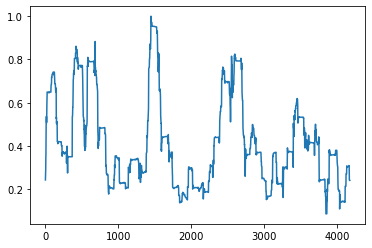

In [65]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

train_vec = np.array(train_vec)
test_vec = np.array(test_vec)

model = NearestNeighbors(n_neighbors=1)
model.fit(train_vec)

dist, _ = model.kneighbors(test_vec)
dist = dist / np.max(dist)

plt.plot(dist)
plt.show()

- sklearn의 NearestNeighbors()를 통해 부분시계열의 파형 거리(유사도)를 측정하였음
- 파형이 닮아 있으면 거리가 가깝고, 닮아 있지 않으면 거리가 멀게 됨
- 임계값 0.8을 기준으로 4개의 이상치를 확인할 수 있음

### 오토 인코더 구조
- 오토 인코더(AE, Auto Encoder)는 신경망 중 하나인 네트워크 형태임
- 비지도학습, 차원압축의 알고리즘이기에 입력되는 것은 설명변수 밖에 없음(라벨 x)
- 출력값과 입력값의 오차가작아지게 만들도록 학습하여 모델을 작성함
- 입력층에서 중간층을 향해서 정보량을 압축(인코더), 중간층에서 출력층을 향해 정보를 복원(디코더)함
- 중간층에서는 압축된 입력의 특징량을 추출할 수 있음

### 오토 인코더에 의한 훈련 데이터 작성
- 오토 인코더의 자기자신을 재현하는 성질을 활용하여 이상 징후 검출이 가능
- 출력값과 입력값의 차이(예측오차)를 이상 스코어로 정의함

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(144,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(144, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='mse', optimizer='adam')

hist = model.fit(train_vec, train_vec, batch_size=128, 
                 verbose=1, epochs=20, validation_split=0.2)

In [ ]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(test_vec)

plt.plot(test_vec[:,0], label='test')
plt.plot(pred[:,0], label='pred')
plt.legend()
plt.show()

In [ ]:
dist = test_vec[:,0] - pred[:,0]
dist = pow(dist, 2)
dist = dist / np.max(dist)

plt.plot(dist)
plt.show()

- 위와 같이 전처리한 데이터를 Keras를 활용하여 학습 수행(TF, Keras 버전 매칭 때문에 실행하지 않음)